In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [2]:
nx = 9
ny = 6

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

fnames = glob.glob("camera_cal/calibration*.jpg")

for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape,None,None)
print("done")

done


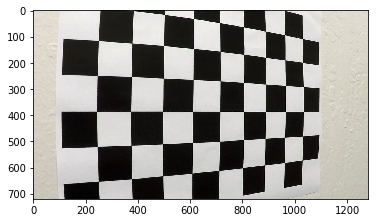

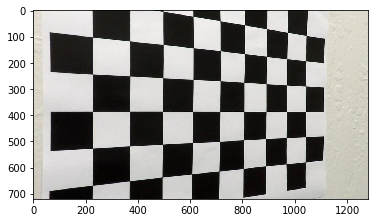

In [3]:
img = mpimg.imread(fnames[15])
plt.imshow(img)
plt.show()
dst = cv2.undistort(img, mtx, dist, None, None)
plt.imshow(dst)
plt.show()

In [4]:
def undist(image):
    dst = cv2.undistort(image, mtx, dist, None, None)
    return dst

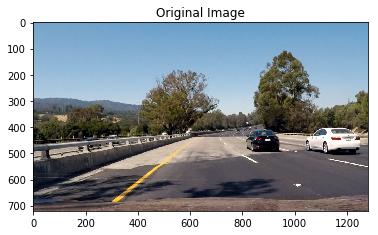

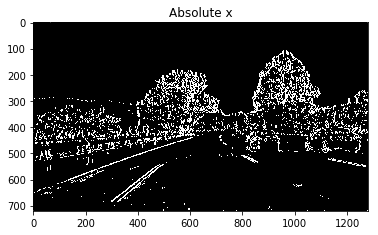

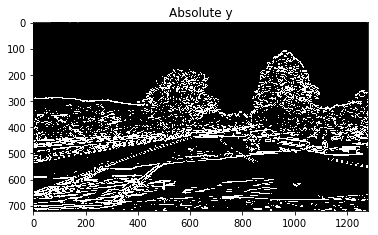

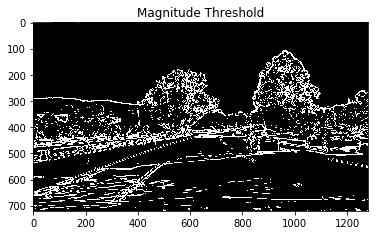

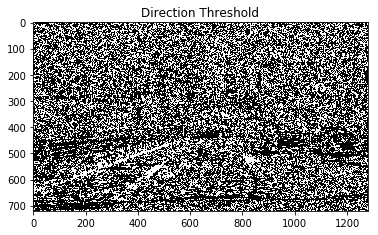

done


In [5]:
#Gradient and direction threshold
def magthresh(image):
    kernel = 9
    mag = (30, 100)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #Sobel x and y gradients 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel)
    #gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    outp = np.zeros_like(gradmag)
    outp[(gradmag >= mag[0]) & (gradmag <= mag[1])] = 1
    return outp

def abs_sobel(image):
    kernel = 9
    thresh_min = 20
    thresh_max = 100
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel)
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    scaledx = np.uint8(255*sobelx/np.max(sobelx))
    scaledy = np.uint8(255*sobely/np.max(sobely))

    arrx = np.zeros(scaledx.shape)
    arry = np.zeros(scaledy.shape)
    arrx[(scaledx>=thresh_min) & (scaledx<=thresh_max)] = 1
    arry[(scaledy>=thresh_min) & (scaledy<=thresh_max)] = 1
    
    return arrx, arry

def dirthresh(image):
    sobel_kernel = 15
    thresh=(0.7, 1.3)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output



image = mpimg.imread("test_images/test4.jpg")
plt.imshow(image)
plt.title("Original Image")
plt.show()
temp1,temp2 = abs_sobel(image)
plt.imshow(temp1, cmap = "gray")
plt.title("Absolute x")
plt.show()
plt.imshow(temp2, cmap = "gray")
plt.title("Absolute y")
plt.show()
    
temp = magthresh(image)
plt.imshow(temp, cmap="gray")
plt.title("Magnitude Threshold")
plt.show()

plt.show()
temp = dirthresh(image)
plt.imshow(temp, cmap="gray")
plt.title("Direction Threshold")
plt.show()
print("done")

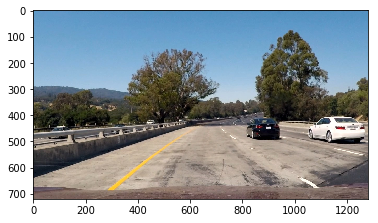

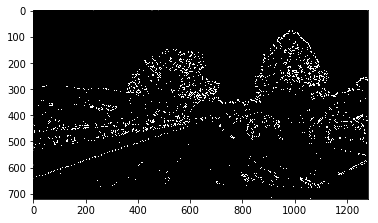

In [6]:
#Combine Gradient Thresholds
def combinegrad(image):
    dir1 = dirthresh(image)
    mag1 = magthresh(image)
    absx, absy = abs_sobel(image)
    combined = np.zeros_like(dir1)
    combined[((absx == 1) & (absy == 1)) ] = 1
    return combined

imaag = mpimg.imread("test_images/test1.jpg")
temp = combinegrad(imaag)
plt.imshow(imaag)
plt.show()
plt.imshow(temp, cmap = 'gray')
plt.show()

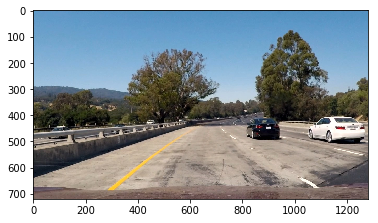

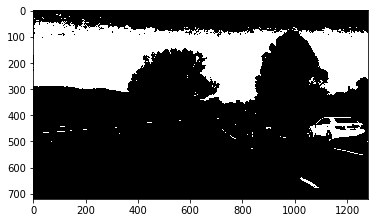

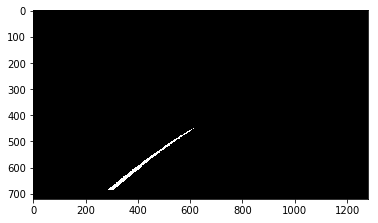

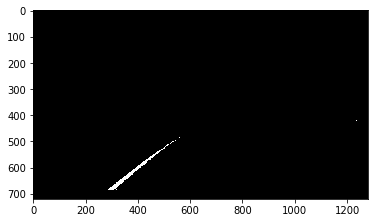

In [7]:
#Color Thresholding 


def colorthresh(image):
    thresh = [20, 255]
    r1 = np.zeros(image.shape)
    r2 = np.zeros(image.shape)
    r3 = np.zeros(image.shape)
    
    #white colour thresholding rgb 
    low1 = np.array([100,100,200])
    high1 = np.array([255,255,255])
    mask = cv2.inRange(image, low1, high1)
    rgbw = cv2.bitwise_and(image, image, mask = mask)
    rgbw = cv2.cvtColor(rgbw, cv2.COLOR_RGB2GRAY)
    #defining r1,r2,r3 with shape of rgbw
    r1 = np.zeros(rgbw.shape)
    r2 = np.zeros(rgbw.shape)
    r3 = np.zeros(rgbw.shape)
    r1[(rgbw>=20) & (rgbw<=255)] = 1
    
    #yellow colour thresholding rgb
    low1 = np.array([225,180,0])
    high1 = np.array([255,255,170])
    mask = cv2.inRange(image, low1, high1)
    rgby = cv2.bitwise_and(image, image, mask = mask)
    rgby = cv2.cvtColor(rgby, cv2.COLOR_RGB2GRAY)
    r2[(rgby>=20) & (rgby<=255)] = 1
    
    #yellow colour thresholding hls
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    low1 = np.array([20,120,80])
    high1 = np.array([45, 200, 255])
    mask = cv2.inRange(hls, low1, high1)
    hlsy = cv2.bitwise_and(hls, hls, mask=mask)
    hlsy = cv2.cvtColor(hlsy, cv2.COLOR_HLS2RGB)
    hlsy = cv2.cvtColor(hlsy, cv2.COLOR_RGB2GRAY)
    r3[(hlsy>=20) & (hlsy<=255)]=1
    
    return r1, r2, r3

image = mpimg.imread("test_images/test1.jpg")
plt.imshow(image)
plt.show()
x,y,z = colorthresh(image)
plt.imshow(x, cmap = 'gray')
plt.show()
plt.imshow(y, cmap = 'gray')
plt.show()
plt.imshow(z, cmap = 'gray')
plt.show()

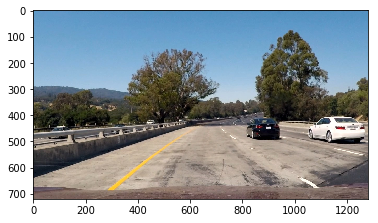

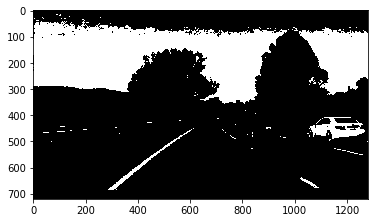

In [8]:
#Combine Colour Thresholds
def combcolor(image):
    r1,r2,r3 = colorthresh(image)
    ans = np.zeros(r1.shape)
    ans[(r1==1)|(r2==1)|(r3==1)] = 1
    return ans

image = mpimg.imread("test_images/test1.jpg")
temp = combcolor(image)
plt.imshow(image)
plt.show()
plt.imshow(temp, cmap='gray')
plt.show()

(720, 1280, 3)


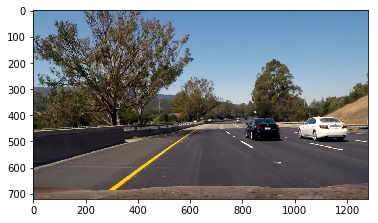

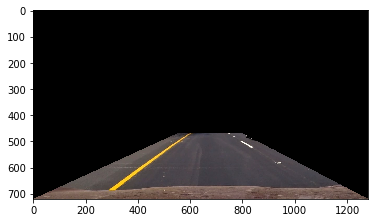

In [9]:
image = mpimg.imread("test_images/test6.jpg")
def region_of_interest(img):
    imshape = img.shape
    vertices = np.array([[(0,imshape[0]),(550, 470), (800, 470), (imshape[1],imshape[0])]], dtype=np.int32)

    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

imshape = image.shape
print(imshape)
vertices = np.array([[(75,imshape[0]), (500,400), (750,400), (imshape[1]-75,imshape[0])]], dtype=np.int32)
mask_image = region_of_interest(image)
plt.imshow(image)
plt.show()
plt.imshow(mask_image)
plt.show()

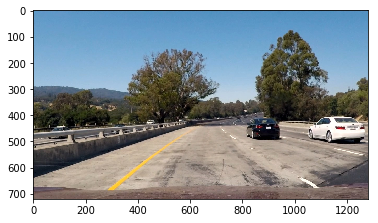

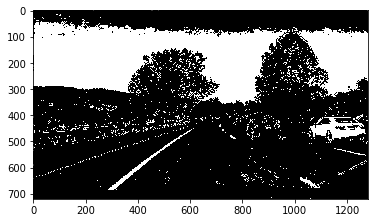

In [10]:
#Combine Color and gradient threshholds
def fincombine(image):
    colth = combcolor(image)
    #plt.imshow(colth, cmap='gray')
    #plt.show()
    gradth = combinegrad(image)
    #plt.imshow(gradth, cmap = 'gray')
    #plt.show()
    binary = np.zeros_like(colth, dtype = np.uint8)
    binary[(colth==1)|(gradth==1)]=1
    return binary

image = mpimg.imread("test_images/test1.jpg")
temp = fincombine(image)
plt.imshow(image)
plt.show()
plt.imshow(temp, cmap = 'gray')
plt.show()

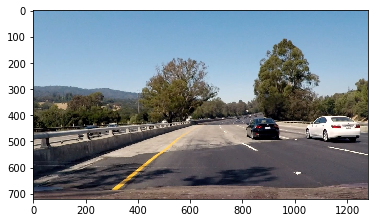

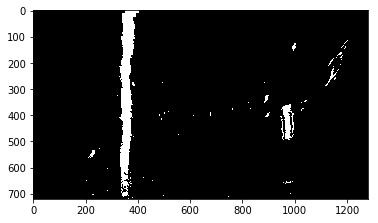

In [11]:
#Perspective Transform
def perspect(imag):
    #print(imag.dtype)
    imag = undist(imag)
    #print(imag.dtype)
    image = fincombine(imag)
    #print(image.dtype)
    image = region_of_interest(image)
    
    rows,cols = image.shape

    pt1 = np.float32([[220,720],[570, 470],[722, 470],[1110, 720]]) 
    pt2 = np.float32([[320,720],[320, 1],[920, 1],[920, 720]])
    #pt2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])
    
    Minv = cv2.getPerspectiveTransform(pt2, pt1)
    M = cv2.getPerspectiveTransform(pt1, pt2)
    dst = cv2.warpPerspective(image, M, (cols, rows), flags=cv2.INTER_LINEAR) 
    return dst, Minv

image = mpimg.imread("test_images/test4.jpg")
plt.imshow(image)
plt.show()
temp, _ = perspect(image)
plt.imshow(temp, cmap = 'gray')
plt.show()


(720, 1280)


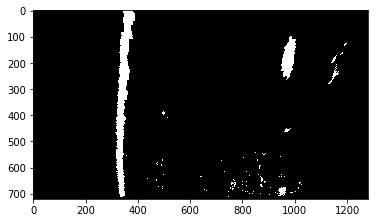

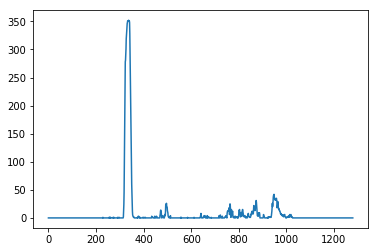

In [12]:
image = mpimg.imread("test_images/test1.jpg")
temp, _ = perspect(image)
print(temp.shape)
plt.imshow(temp,cmap = 'gray')
plt.show()
histogram = np.sum(temp[temp.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()


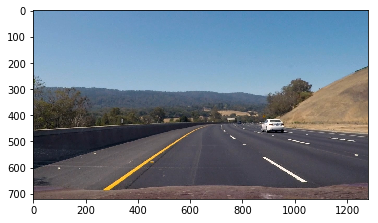

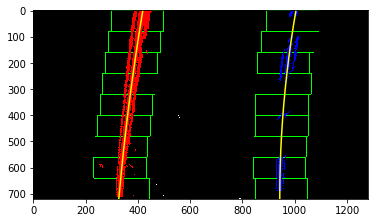

In [99]:
#Defining below function for showing lane line on warped image, the complete finlines pipeling defined below
def findlines1(img):
    image1 = img
    img, Minv = perspect(img)
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #Visualize
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')


img = mpimg.imread("test_images/test3.jpg")
plt.imshow(img)
plt.show()
findlines1(img)
#print(temp.shape)
plt.show()


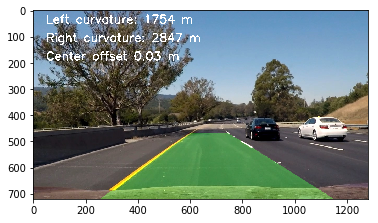

In [100]:
def findlines(img):
    image1 = img
    img, Minv = perspect(img)
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        #(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        #(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #Visualize
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    
    
    #Drawing
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image1.shape[1], image1.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image1, 1, newwarp, 0.3, 0)
    
    

    #Curvature
    #ploty , left_fit, right_fit
    y_eval = np.max(ploty)
    '''
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    '''
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #print(left_curverad, 'm', right_curverad, 'm')
    #print(y_eval)
    
    
    #Drawing curvature and center of road
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    fontScale = 1.5
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), font, fontScale, fontColor, 3)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), font, fontScale, fontColor, 3)
    
    #offset calculation
    xMax = result.shape[1]*xm_per_pix
    yMax = result.shape[0]*ym_per_pix
    vcent = xMax / 2
    leftline = left_fit_cr[0]*yMax**2 + left_fit_cr[1]*yMax + left_fit_cr[2]
    rightline = right_fit_cr[0]*yMax**2 + right_fit_cr[1]*yMax + right_fit_cr[2]
    midline = leftline + (rightline - leftline)/2
    centeroff = midline - vcent
    
    cv2.putText(result, 'Center offset {:.2f} m'.format(centeroff), (50, 190), font, 1.5, fontColor, 3)
    
    plt.imshow(result)
    return result

img = mpimg.imread("test_images/test6.jpg")
temp = findlines(img)
#print(temp.shape)
plt.show()


In [101]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [102]:
white_output = 'white.mp4'

myclip = VideoFileClip("project_video.mp4")
clip = myclip.fl_image(findlines)
clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 1260/1261 [07:34<00:00,  2.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

